<a href="https://colab.research.google.com/github/lingmHVAC/lingmHVAC/blob/main/Dec17_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


FITTED PARAMETERS
J_in = 5.714 #/cm3/s
C_g  = 0.0000 µm/s
K    = 2.58e-22 cm3/s


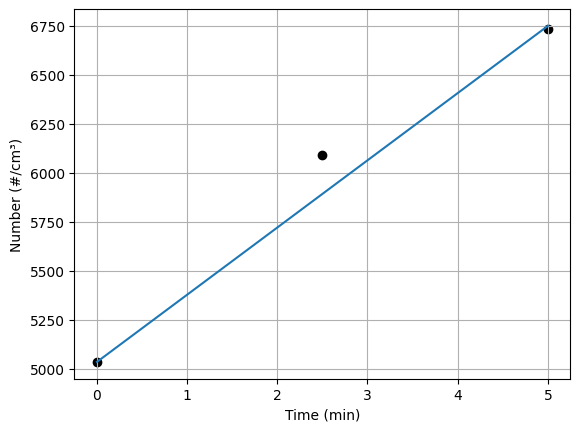

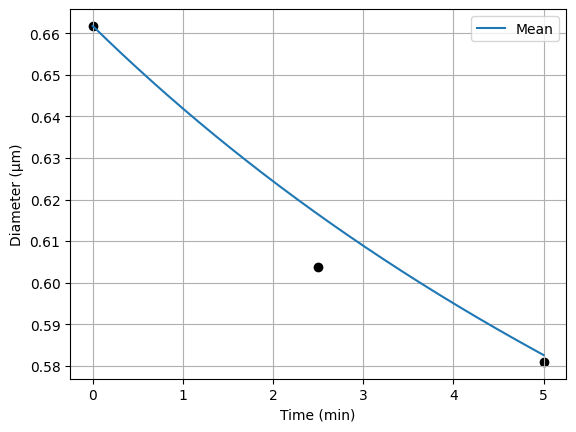

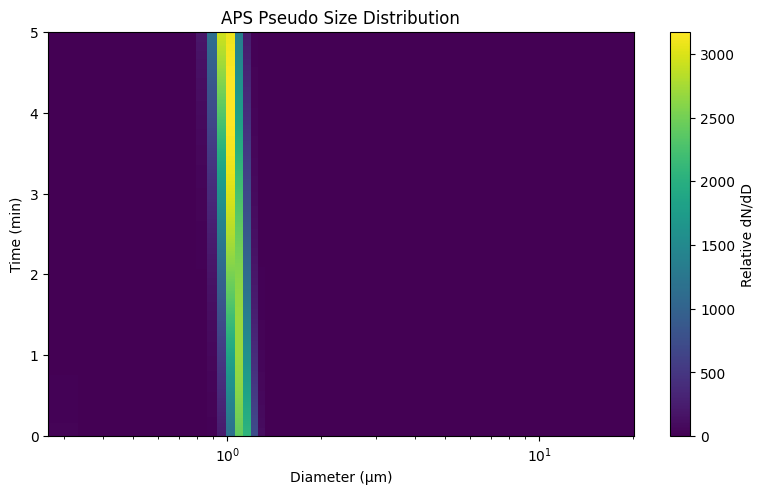

In [3]:
# coagulation and injection, with condensation
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# ============================================================
# APS MEASURED MOMENTS (µm, #/cm3)
# ============================================================
t_data = np.array([0.0, 150.0, 300.0])  # seconds

M_data = np.array([
    [5035, 3332, 3229, 8641],
    [6091, 3678, 3059, 8100],
    [6734, 3912, 3037, 8551]
])

din = 0.35  # µm (sub-APS injected size)

# ============================================================
# MOMENT ODE SYSTEM
# ============================================================
def moment_rhs(t, y, Jin, Cg, K):
    M0, M1, M2, M3 = y

    dM0 = Jin - 0.5 * K * M0**2
    dM1 = Jin * din + Cg * M0
    dM2 = Jin * din**2 + 2 * Cg * M1 + K * M1**2
    dM3 = Jin * din**3 + 3 * Cg * M2 + 3 * K * M1 * M2

    return [dM0, dM1, dM2, dM3]

# ============================================================
# CALIBRATION OBJECTIVE
# ============================================================
def residuals(params):
    Jin, Cg, K = params

    sol = solve_ivp(
        lambda t, y: moment_rhs(t, y, Jin, Cg, K),
        [0, t_data[-1]],
        M_data[0],
        t_eval=t_data,
        rtol=1e-9
    )

    return (sol.y.T - M_data).ravel()

# ============================================================
# PARAMETER FIT
# ============================================================
guess = [6.0, 0.002, 3e-10]
bounds = ([0.0, 0.0, 0.0], [50.0, 0.05, 1e-8])

res = least_squares(residuals, guess, bounds=bounds)

Jin, Cg, K = res.x

print("\nFITTED PARAMETERS")
print(f"J_in = {Jin:.3f} #/cm3/s")
print(f"C_g  = {Cg:.4f} µm/s")
print(f"K    = {K:.2e} cm3/s")

# ============================================================
# FULL TRAJECTORY
# ============================================================
t_eval = np.linspace(0, 300, 400)

sol = solve_ivp(
    lambda t, y: moment_rhs(t, y, Jin, Cg, K),
    [0, 300],
    M_data[0],
    t_eval=t_eval
)

M0, M1, M2, M3 = sol.y

mean_d = M1 / M0
geo_d = np.exp(np.log(M2/M0) - 2*np.log(mean_d))

# ============================================================
# 2-NODE QMOM RECONSTRUCTION
# ============================================================
var = M2/M0 - mean_d**2
std = np.sqrt(np.maximum(var, 1e-12))

d1 = mean_d - std
d2 = mean_d + std
w1 = 0.5 * M0
w2 = 0.5 * M0

mode = np.where(w1 * d1 > w2 * d2, d1, d2)

# ============================================================
# APS PSEUDO DISTRIBUTION
# ============================================================
Dgrid = np.linspace(0.3, 20.0, 300)
pdf = np.zeros((len(t_eval), len(Dgrid)))

for i in range(len(t_eval)):
    pdf[i] = (
        w1[i] * np.exp(-(Dgrid - d1[i])**2 / (2*0.03**2)) +
        w2[i] * np.exp(-(Dgrid - d2[i])**2 / (2*0.07**2))
    )

# ============================================================
# PLOTS
# ============================================================
plt.figure()
plt.plot(t_eval/60, M0)
plt.scatter(t_data/60, M_data[:,0], c='k')
plt.ylabel("Number (#/cm³)")
plt.xlabel("Time (min)")
plt.grid()

plt.figure()
plt.plot(t_eval/60, mean_d, label="Mean")
#plt.plot(t_eval/60, mode, '--', label="Mode")
plt.scatter(t_data/60, M_data[:,1]/M_data[:,0], c='k')
plt.ylabel("Diameter (µm)")
plt.xlabel("Time (min)")
plt.legend()
plt.grid()

plt.figure(figsize=(8,5))
plt.pcolormesh(Dgrid, t_eval/60, pdf, shading='auto')
plt.xlabel("Diameter (µm)")
plt.ylabel("Time (min)")
plt.title("APS Pseudo Size Distribution")
plt.colorbar(label="Relative dN/dD")
plt.tight_layout()
plt.xscale('log')
plt.show()
